In [ ]:
CHALLENGE - 3 - sentiment analysis

In [1]:
#importing 

import pandas as pd

file_name = 'tweet_data.csv'
df = pd.read_csv(file_name)

In [2]:
df.head(2)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612.0,ketuesriche,551,351,NaN,NaN,NaN,Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92.0,Grid1949,66,92,NaN,NaN,NaN,"Edinburgh, Scotland"


In [3]:
df.shape

(6532, 15)

In [4]:
df.columns

Index(['created_at', 'source', 'original_text', 'polarity', 'subjectivity',
       'lang', 'favorite_count', 'retweet_count', 'original_author',
       'followers_count', 'friends_count', 'possibly_sensitive', 'hashtags',
       'user_mentions', 'place'],
      dtype='object')

In [5]:
count_texts = df['original_text'].isnull().sum()
print("Data Frame before removing null rows ", df.shape)
print("Number of null orignal_text ", count_texts)

Data Frame before removing null rows  (6532, 15)
Number of null orignal_text  2812


In [6]:
df = df[~df['original_text'].isnull()]
count_texts = df['original_text'].isnull().sum()
print("Data Frame after removing null rows ", df.shape)
print("Number of null orignal_text ", count_texts)

Data Frame after removing null rows  (3720, 15)
Number of null orignal_text  0


In [7]:
import re
def clean_text(text):
    hash_tag_removed = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
    removed_links = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', hash_tag_removed, flags=re.MULTILINE)
    result = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', removed_links)
    return result

df['original_text'] = df['original_text'].apply(clean_text)

In [8]:
cleanTweet = pd.DataFrame()
cleanTweet['clean_text'] = df['original_text']
cleanTweet['polarity'] = df['polarity']

cleanTweet.head()

,clean_text,polarity
0,"🚨Africa is ""in the midst of a full-blown third...",0.166667
1,"Dr Moeti is head of WHO in Africa, and one of ...",0.133333
2,Thank you for creating this amazing campaign ...,0.316667
3,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111
4,I think it’s important that we don’t sell COVA...,0.280000


In [9]:
def text_category(polarity):
    if (polarity > 0):
        return 'positive'
    elif (polarity < 0):
        return 'negative'
    else:
        return 'neutral'
positive_polarity = len(cleanTweet[cleanTweet['polarity'] > 0])
negative_polarity = len(cleanTweet[cleanTweet['polarity'] < 0])
neutral_polarity = len(cleanTweet[cleanTweet['polarity'] == 0])
print("Positive Polaritys ", positive_polarity)
print("Negative Polaritys ", negative_polarity)
print("Neutral_polarity ", neutral_polarity)

cleanTweet['score'] = cleanTweet['polarity'].apply(text_category)
cleanTweet['score'].value_counts()

Positive Polaritys  2786
Negative Polaritys  568
Neutral_polarity  366


positive    2786
negative     568
neutral      366
Name: score, dtype: int64

In [ ]:
Visualization of cleaned data

<AxesSubplot:>

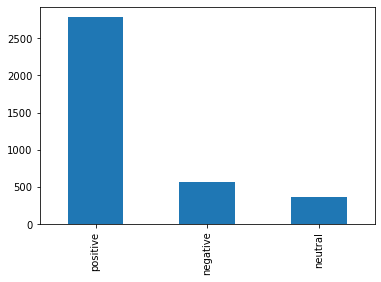

In [10]:
score_count = cleanTweet['score'].value_counts()
score_count.plot(kind='bar')

<AxesSubplot:ylabel='score'>

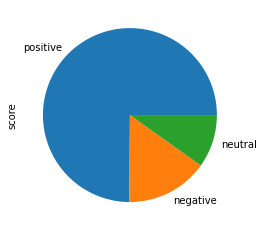

In [11]:
score_count.plot(kind='pie')

In [12]:
score_types = cleanTweet['score'].value_counts()

cleanTweet = cleanTweet[cleanTweet['score'] != 'neutral']

check_score_types = cleanTweet['score'].value_counts()

print("Before Removing neutral\n", score_types)
print("After Removing neutral\n", check_score_types)

Before Removing neutral
 positive    2786
negative     568
neutral      366
Name: score, dtype: int64
After Removing neutral
 positive    2786
negative     568
Name: score, dtype: int64


In [ ]:
ANALIZATION

In [13]:
cleanTweet['score_map'] = cleanTweet['score'].apply(lambda x: 1 if x == 'positive' else 0)
cleanTweet['score_map'].value_counts()

1    2786
0     568
Name: score_map, dtype: int64

In [ ]:
VICTORIZATION 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [20]:
# Input and output
(X, y) = cleanTweet['clean_text'], cleanTweet['score_map']

# Trigram Vecrorization
trigram_vectorization = CountVectorizer(ngram_range=(3,3))
trigram_vectorization.fit(X.values)
x_trigram = trigram_vectorization.transform(X.values)

# Trigram TFIDF
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_trigram)
x_tfidf = tfidf_transformer.transform(x_trigram)


In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np

def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')


In [ ]:
TRANING

In [23]:
train_and_show_scores(x_trigram, y, title='TRIAGRAM')


TRIAGRAM
Train score: 1.0 ; Validation score: 0.98



In [24]:
train_and_show_scores(x_tfidf, y, title='TFIDF')

TFIDF
Train score: 1.0 ; Validation score: 0.97

